# Permutations

In [1]:
import fst

## Helper code

Let's start by defining a few functions that will help us construct and inspect automata

In [30]:
# Let's see the input as a simple linear chain FSA
def make_input(srcstr, sigma = None):
    """
    converts a nonempty string into a linear chain acceptor
    @param srcstr is a nonempty string
    @param sigma is the source vocabulary
    """
    assert(srcstr.split())
    return fst.linear_chain(srcstr.split(), sigma)

In [31]:
# this function will enumerate all paths in an automaton
def enumerate_paths(fsa):
    paths = [[str(arc.ilabel) for arc in path] for path in fsa.paths()]
    print len(paths), 'paths:'
    for path in paths:
        print ' '.join(path)

In [3]:
# I am going to start with a very simple wrapper for a python dictionary that
# will help us associate unique ids to items
# this wrapper simply offers one aditional method (insert) similar to the insert method of an std::map
class ItemFactory(object):
    
    def __init__(self):
        self.nextid_ = 0
        self.i2s_ = {}
        
    def insert(self, item):
        """
        Inserts a previously unmapped item.
        Returns the item's unique id and a flag with the result of the intertion.
        """
        uid = self.i2s_.get(item, None)
        if uid is None:
            uid = self.nextid_
            self.nextid_ += 1
            self.i2s_[item] = uid
            return uid, True
        return uid, False
    
    def get(self, item):
        """
        Returns the item's unique id (assumes the item has been mapped before)
        """
        return self.i2s_[item]

## All permutations

In [4]:
# This program packs all permutations of an input sentence
def Permutations(sentence, sigma=None, delta=None):
    from collections import deque
    from itertools import takewhile
    A = fst.Transducer(isyms=sigma, osyms=delta)
    I = len(sentence)
    axiom = tuple([False]*I)
    ifactory = ItemFactory()
    ifactory.insert(axiom)
    Q = deque([axiom])
    while Q:
        ant = Q.popleft() # antecedent (coverage vector)
        sfrom = ifactory.get(ant) # state id
        if all(ant): # goal item
            A[sfrom].final = True # is a final node
            continue       
        for i in range(I):
            if not ant[i]:
                cons = list(ant)
                cons[i] = True
                cons = tuple(cons)
                sto, new = ifactory.insert(cons)
                if new:
                    Q.append(cons)
                A.add_arc(sfrom, sto, str(i + 1), sentence[i], 0)
    return A   

## Window of length *d*

Here we keep track of a coverage vector (C) of length *d* starting from the leftmost uncovered word (l)

* [l, C]

There are two inference rules: one moves the window ahead whenever the leftmost uncovered position chances; and another that fills up the window without touching the leftmost input word.

In [5]:
# Let's define a model of translational equivalences that performs word replacement of arbitrary permutations of the input
# constrained to a window of length $d$ (see WLd in (Lopez, 2009)) 
# same strategy in Moses (for phrase-based models)
def WLdPermutations(sentence, d = 2, sigma = None, delta = None):
    from collections import deque
    from itertools import takewhile
    A = fst.Transducer(isyms = sigma, osyms = delta)
    I = len(sentence)
    axiom = (1, tuple([False]*min(I - 1, d - 1)))
    ifactory = ItemFactory()
    ifactory.insert(axiom)
    Q = deque([axiom])
    while Q:
        ant = Q.popleft() # antecedent
        l, C = ant # signature
        sfrom = ifactory.get(ant) # state id
        if l == I + 1: # goal item
            A[sfrom].final = True # is a final node
            continue
        # adjacent
        n = 0 if (len(C) == 0 or not C[0]) else sum(takewhile(lambda b : b, C)) # leading ones
        ll = l + n + 1
        CC = list(C[n+1:])
        maxlen = min(I - ll, d - 1)
        if maxlen:
            m = maxlen - len(CC) # missing positions
            [CC.append(False) for _ in range(m)]
        cons = (ll, tuple(CC))
        sto, inserted = ifactory.insert(cons)
        if inserted:
            Q.append(cons)
        A.add_arc(sfrom, sto, str(l), sentence[l-1], 0)
        # non-adjacent
        ll = l
        for i in range(l + 1, I + 1):
            if i - l + 1 > d: # beyond limit
                break
            if C[i - l - 1]: # already used
                continue
            # free position
            CC = list(C)
            CC[i-l-1] = True
            cons = (ll, tuple(CC))
            sto, inserted = ifactory.insert(cons)
            if inserted:
                Q.append(cons)
            A.add_arc(sfrom, sto, str(i), sentence[i-1], 0)
    return A   

# Examples

In [6]:
# Let's create a table for the input vocabulary $\Sigma$
sigma = fst.SymbolTable()
# and for the output vocabulary $\Delta$
delta = fst.SymbolTable()

## Input

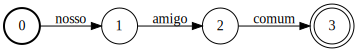

In [7]:
# Let's have a look at the input as an automaton
# we call it F ('f' is the cannonical source language)
ex1_F = make_input('nosso amigo comum', sigma)
ex1_F

## All permutations

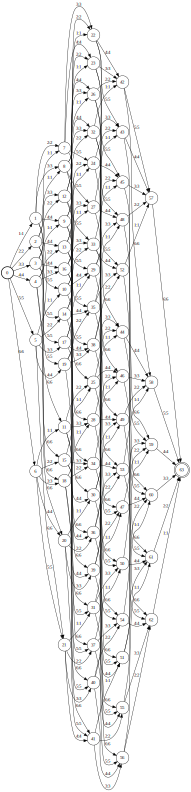

In [45]:
ex1_all = Permutations('1 2 3 4 5 6'.split(), None, sigma)
ex1_all

For a toy example we can enumerate the permutations

In [46]:
enumerate_paths(ex1_all)

720 paths:
1 2 3 4 5 6
1 2 3 4 6 5
1 2 3 5 4 6
1 2 3 5 6 4
1 2 3 6 4 5
1 2 3 6 5 4
1 2 4 3 5 6
1 2 4 3 6 5
1 2 4 5 3 6
1 2 4 5 6 3
1 2 4 6 3 5
1 2 4 6 5 3
1 2 5 3 4 6
1 2 5 3 6 4
1 2 5 4 3 6
1 2 5 4 6 3
1 2 5 6 3 4
1 2 5 6 4 3
1 2 6 3 4 5
1 2 6 3 5 4
1 2 6 4 3 5
1 2 6 4 5 3
1 2 6 5 3 4
1 2 6 5 4 3
1 3 2 4 5 6
1 3 2 4 6 5
1 3 2 5 4 6
1 3 2 5 6 4
1 3 2 6 4 5
1 3 2 6 5 4
1 3 4 2 5 6
1 3 4 2 6 5
1 3 4 5 2 6
1 3 4 5 6 2
1 3 4 6 2 5
1 3 4 6 5 2
1 3 5 2 4 6
1 3 5 2 6 4
1 3 5 4 2 6
1 3 5 4 6 2
1 3 5 6 2 4
1 3 5 6 4 2
1 3 6 2 4 5
1 3 6 2 5 4
1 3 6 4 2 5
1 3 6 4 5 2
1 3 6 5 2 4
1 3 6 5 4 2
1 4 2 3 5 6
1 4 2 3 6 5
1 4 2 5 3 6
1 4 2 5 6 3
1 4 2 6 3 5
1 4 2 6 5 3
1 4 3 2 5 6
1 4 3 2 6 5
1 4 3 5 2 6
1 4 3 5 6 2
1 4 3 6 2 5
1 4 3 6 5 2
1 4 5 2 3 6
1 4 5 2 6 3
1 4 5 3 2 6
1 4 5 3 6 2
1 4 5 6 2 3
1 4 5 6 3 2
1 4 6 2 3 5
1 4 6 2 5 3
1 4 6 3 2 5
1 4 6 3 5 2
1 4 6 5 2 3
1 4 6 5 3 2
1 5 2 3 4 6
1 5 2 3 6 4
1 5 2 4 3 6
1 5 2 4 6 3
1 5 2 6 3 4
1 5 2 6 4 3
1 5 3 2 4 6
1 5 3 2 6 4
1 5 3 4 2 6
1 5 3 4 6 2
1 5 3

## WL*d*

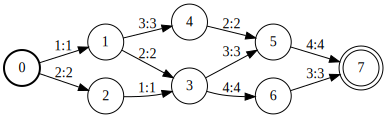

In [41]:
# these are the permutations of the input according to WL$2$
ex2_WLd2 = WLdPermutations('1 2 3 4'.split(), 2, None, sigma)
ex2_WLd2

In [42]:
enumerate_paths(ex2_WLd2)

5 paths:
1 2 3 4
1 2 4 3
1 3 2 4
2 1 3 4
2 1 4 3
